In [533]:
import pandas as pd
import scipy.stats as ss
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

In [534]:
train_y = pd.read_csv('../../data/raw/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
train_x = pd.read_csv('../../data/raw/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
train = train_x.merge(train_y)

X_train, _, _, _ = train_test_split(train_x, train_y, random_state=42)
print(train.shape, X_train.shape)

(59400, 41) (44550, 40)


# Data cleaning

To do list:
- redundant information
- missing values
- categorical features
- normalization

The description of the features is found in the competition page:

- `amount_tsh` - Total static head (amount water available to waterpoint)
- `date_recorded` - The date the row was entered
- `funder` - Who funded the well
- `gps_height` - Altitude of the well
- `installer` - Organization that installed the well
- `longitude` - GPS coordinate
- `latitude` - GPS coordinate
- `wpt_name` - Name of the waterpoint if there is one
- `num_private` -
- `basin` - Geographic water basin
- `subvillage` - Geographic location
- `region` - Geographic location
- `region_code` - Geographic location (coded)
- `district_code` - Geographic location (coded)
- `lga` - Geographic location
- `ward` - Geographic location
- `population` - Population around the well
- `public_meeting` - True/False
- `recorded_by` - Group entering this row of data
- `scheme_management` - Who operates the waterpoint
- `scheme_name` - Who operates the waterpoint
- `permit` - If the waterpoint is permitted
- `construction_year` - Year the waterpoint was constructed
- `extraction_type` - The kind of extraction the waterpoint uses
- `extraction_type_group` - The kind of extraction the waterpoint uses
- `extraction_type_class` - The kind of extraction the waterpoint uses
- `management` - How the waterpoint is managed
- `management_group` - How the waterpoint is managed
- `payment` - What the water costs
- `payment_type` - What the water costs
- `water_quality` - The quality of the water
- `quality_group` - The quality of the water
- `quantity` - The quantity of water
- `quantity_group` - The quantity of water
- `source` - The source of the water
- `source_type` - The source of the water
- `source_class` - The source of the water
- `waterpoint_type` - The kind of waterpoint
- `waterpoint_type_group` - The kind of waterpoint

## redundancy

Some features seem very correlated, even just looking at their descriptions:
- `longitude`, `latitude`, `basin`, `subvillage`, `region`, `region_code`, `district_code`, `lga`, `ward`: Geographic location
- `scheme_management`, `scheme`:  Who operates the waterpoint
- `extraction_type`, `extraction_type_group`, `extraction_type_class`: The kind of extraction the waterpoint uses
- `management`, `management_group`: How the waterpoint is managed
- `payment`, `payment_type`: What the water costs
- `water_quality`, `quality_group`: The quality of the water
- `quantity`, `quantity_group`: The quantity of water
- `source`, `source_type`, `source_class`: The source of the water
- `waterpoint_type`, `waterpoint_type_group`: The kind of waterpoint

It may not make sense to process all of these features if they are very correlated to begin with, so I will take a look at these groups first!

### geographic location

In [535]:
geo = ['longitude', 'latitude', 'basin', 'subvillage', 'region', 
       'region_code', 'district_code', 'lga', 'ward']

In [536]:
msno.matrix(train[geo].sample(500))
plt.show()

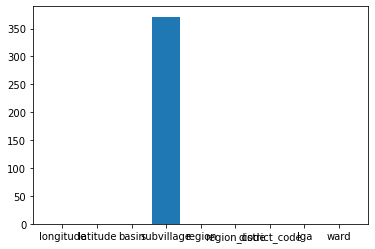

In [537]:
plt.bar(geo, train[geo].isna().sum())
plt.show()

actual NAs only on `subvillage`, but it is possible that there are "filled" missing values in the other feature columns as well. I will go over them and try to spot them to get a better picture of how complete each feature is.

In [538]:
train.loc[:, geo].nunique()

longitude        57516
latitude         57517
basin                9
subvillage       19287
region              21
region_code         27
district_code       20
lga                125
ward              2092
dtype: int64

Latitude and longitude are interesting because they are numerical values that encode locations with high detail, and there is a numerical relationship between these values (i.e. they are not classes, they are measures and there is a constancy in what a difference in latitudes means). So these features interest me to begin with as a way to encode geographic location.

The `basin` feature is interesting because despite relating very highly with the geographic location, it also encodes information concerning the water available in each location. Besides this, there is a reasonable number of categories, so one-hot encoding them will not be very dramatic in terms of increase of the feature space's dimensions.

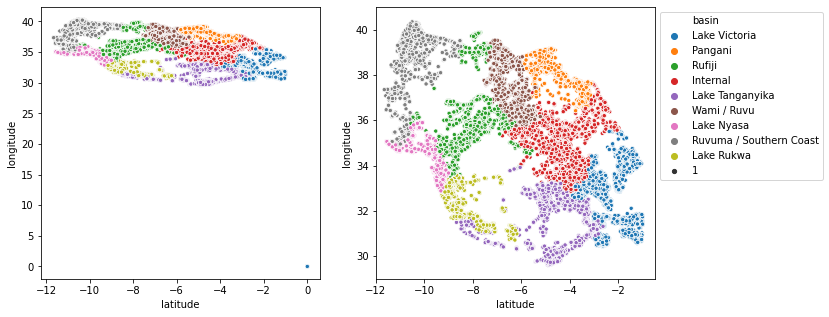

In [539]:
_, ax = plt.subplots(1,2, figsize=(11,5))

sns.scatterplot(data=train, x='latitude', y='longitude', hue='basin',
                hue_order=train.basin.value_counts().keys(), size=1, legend=False, ax=ax[0])
sns.scatterplot(data=train, x='latitude', y='longitude', hue='basin', 
                hue_order=train.basin.value_counts().keys(),size=1, ax=ax[1])

ax[1].set_ylim([29, 41])
ax[1].set_xlim([-12, -0.5])

# lat0, lon0 seem to be missing values?
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Concerning the other geography features:

In [540]:
train[geo[3:]].sample(3)

subvillage     region  region_code  district_code      lga        ward
40349      Koloa   Morogoro            5              4   Ulanga      Isongo
15325    Ngomeni   Morogoro            5              6  Mvomero     Sungaji
7580      Igwata  Shinyanga           17              2    Maswa  Nyabubinza

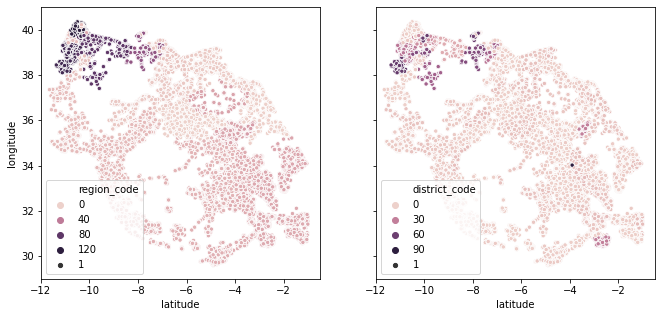

In [541]:
_, ax = plt.subplots(1,2, figsize=(11,5), sharex=True, sharey=True)

ax[0].set_ylim([29, 41])
ax[0].set_xlim([-12, -0.5])

sns.scatterplot(data=train, x='latitude', y='longitude', hue='region_code', size=1, ax=ax[0])
sns.scatterplot(data=train, x='latitude', y='longitude', hue='district_code', size=1, ax=ax[1])

plt.show()

these two features are categories (no numerical relationship) and have many distinct values. They seem very correlated with latitude and longitude, and with each other. For these reasons I would think they won't add a lot of value to a model and will require adding too many dummy features while not adding new information. So I will drop them from the base feature set!

In [542]:
train[geo[3:5] + geo[7:]].sample(3)

subvillage  region     lga     ward
5678     Mtakuja  Dodoma  Kondoa  Masange
45074   Mabatini   Mbeya   Mbozi   Ihanda
7820    Ndengele  Ruvuma  Mbinga    Liuli

In [543]:
train[geo[3:5] + geo[7:]].nunique()

subvillage    19287
region           21
lga             125
ward           2092
dtype: int64

`subvillage` has some missing values. The other three seem to encode geographic location with increasing granularity, but not as much as latitude and longitude.

from this set of features I will keep latitude, longitude and basin. But I will take advantage of these other features to try and impute missing values along these axes! I will see which of these groups are associated to missing latitude and longitudes. Then I will look into how these groups look in terms of lat and long (i.e. not the ones with missing values). Perhaps this can help me infer the missing latitudes and longitudes.

In [544]:
len(train.loc[np.isclose(train.longitude, 0), :])

1812

In [545]:
train.loc[np.isclose(train.longitude, 0), geo].nunique()

longitude          1
latitude           1
basin              2
subvillage       951
region             2
region_code        3
district_code      4
lga                3
ward              69
dtype: int64

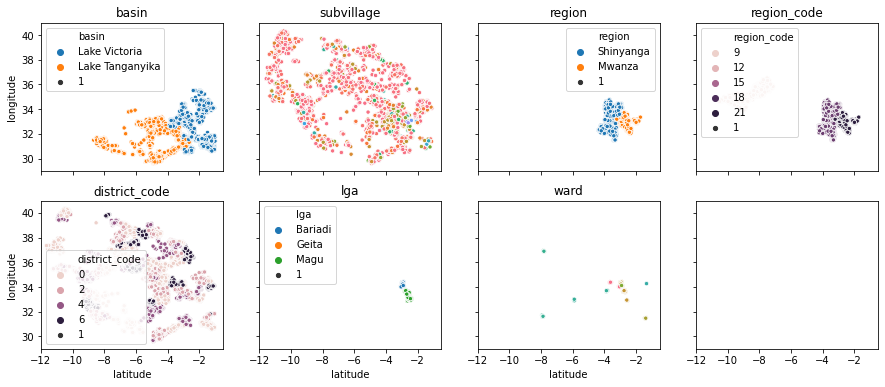

In [546]:
_, ax = plt.subplots(2,4, figsize=(15,6), sharex=True, sharey=True)

ax[0][0].set_ylim([29, 41])
ax[0][0].set_xlim([-12, -0.5])

for i, c in enumerate(geo[2:]):
    vals = train.loc[np.isclose(train.longitude, 0), c].unique()
    
    if c == 'ward' or c == 'subvillage':
        l = False
    else:
        l = 'brief'
    sns.scatterplot(data=train.loc[train[c].isin(vals)], 
                x='latitude', 
                y='longitude',
                hue=c, size=1, legend=l, ax=ax[i//4][i%4])
    
    ax[i//4][i%4].set_title(c)
plt.show()

It is very strange that in some of these metrics, the missing wells are so spread around! Perhaps `subvillage` is tricky (potential small places with same name in different locations). Considering `basin`, `region`, `lga` and part of `region_code`, I would assume the wells to be around the lower-right corner of the visualized region. I will use `region_code` to imput missing coordinate values. I will use the median value of latitude and longitude in each region to replace the 0s.

In [547]:
train_x['longitude_imp'] = train_x['longitude']
train_x['latitude_imp'] = train_x['latitude']

In [548]:
# for this use only the training data (avoid leakage)
coord_imput = X_train.loc[~np.isclose(X_train.longitude, 0), geo].groupby('region_code').median()[['latitude', 'longitude']]
len(coord_imput)

27

In [549]:
for r in train_x.loc[np.isclose(train_x.longitude, 0), 'region_code'].unique():
        
    n = 0
    lat = 0
    lon = 0
    
    try:
        lat = coord_imput.loc[r, 'latitude']
        lon = coord_imput.loc[r, 'longitude']
        n = len(train_x.loc[(np.isclose(train_x.longitude, 0)) & (train_x.region_code == r), :])
        
        train_x.loc[(np.isclose(train_x.longitude, 0)) & (train_x.region_code == r), 'longitude_imp'] = [lon] * n
        train_x.loc[(np.isclose(train_x.longitude, 0)) & (train_x.region_code == r), 'latitude_imp'] = [lat] * n
        
    except KeyError:
        print(f'no imput value for {r}')
        continue

    

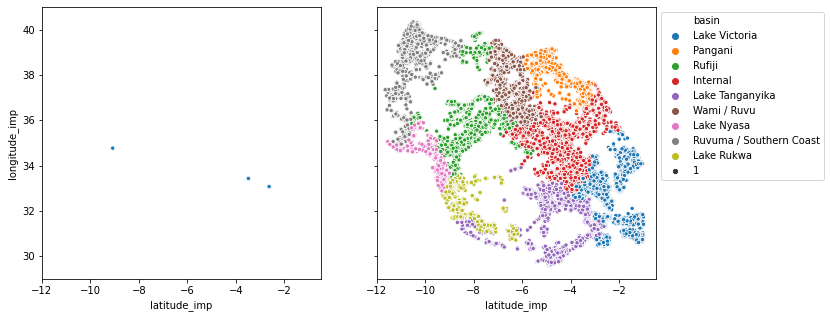

In [550]:
_, ax = plt.subplots(1,2, figsize=(11,5), sharex=True, sharey=True)

ax[0].set_ylim([29, 41])
ax[0].set_xlim([-12, -0.5])

sns.scatterplot(data=train_x.loc[(np.isclose(train_x.longitude, 0)), :], 
                x='latitude_imp', 
                y='longitude_imp',
                hue='basin',
                hue_order=train_x.basin.value_counts().keys(),
                size=1, legend=False, ax=ax[0])
sns.scatterplot(data=train_x, 
                x='latitude_imp',
                y='longitude_imp',
                hue='basin', 
                hue_order=train_x.basin.value_counts().keys(),
                size=1, ax=ax[1])

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

They ended up where expected! And there are no more missing latitude and longitude values. The dataframe with the imputed values must be stored to transform the testing data as well.

In [551]:
coord_imput.to_csv('../../data/external/imput_coords.csv')
# get the train/test split including the imputed coordinates
X_train, _, _, _ = train_test_split(train_x, train_y, random_state=42)

### who operates the waterpoint

In [552]:
op = ['scheme_name', 'scheme_management']

In [553]:
train[op].nunique()

scheme_name          2696
scheme_management      12
dtype: int64

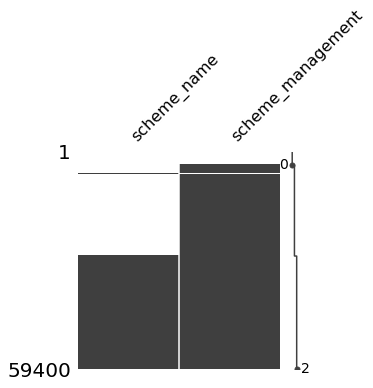

In [554]:
msno.matrix(train[op], figsize=(4,4), sort='ascending')
plt.show()

there are a lot of missing `scheme_name` for which there is a `scheme_management`. There are also less categories in the second, which makes it a better choice of feature.

In [555]:
train['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [556]:
train.loc[train.scheme_management == 'None', op]

scheme_name scheme_management
23603         NaN              None

For this missing value, might as well make it "other".

In [557]:
train.scheme_management = train.scheme_management.fillna('Other')

### kind of extraction

In [558]:
ex = ['extraction_type', 'extraction_type_group', 'extraction_type_class']

In [559]:
train[ex].nunique()

extraction_type          18
extraction_type_group    13
extraction_type_class     7
dtype: int64

In [560]:
msno.matrix(train[ex], figsize=(4,4), sort='ascending')
plt.show()

there are no missing values, so I'll need to look at the values these features takes more closely to decide if it is valuable or not to keep the three (and if not, which one I should choose)

In [561]:
train[ex].sample(5)

extraction_type extraction_type_group extraction_type_class
16045         gravity               gravity               gravity
38675           other                 other                 other
45511           other                 other                 other
43018         gravity               gravity               gravity
18492          swn 80                swn 80              handpump

In [562]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [563]:
cramers = {}
for e in ex:
    cramers[e] = cramers_v(train[e], train['status_group'])

cramers

{'extraction_type': 0.24842745816693432,
 'extraction_type_group': 0.24690148970779827,
 'extraction_type_class': 0.24133876082175432}

does not seem like either feature is particularly strongly correlated to the outcome variable we want to predict. So I will choose the one with least number of unique values to not add too many dummy columns to the data.

In [564]:
train.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

### management

In [565]:
man = ['management', 'management_group', 'scheme_management']

In [566]:
train[man].nunique()

management           12
management_group      5
scheme_management    12
dtype: int64

In [567]:
msno.matrix(train[man], figsize=(4,4), sort='ascending')
plt.show()

In [568]:
cramers = {}
for m in man:
    cramers[m] = cramers_v(train[m], train['status_group'])

cramers

{'management': 0.13165596946454589,
 'management_group': 0.0485185288205425,
 'scheme_management': 0.12759079910352308}

In [569]:
train['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

perhaps `other`, `unknown` can be merged together, and `other - school` become just `school`.

In [570]:
train_x['management'] = train_x['management'].replace('unknown', 'other')
train_x['management'] = train_x['management'].replace('other - school', 'school')
train_x['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
other                1405
water authority       904
company               685
school                 99
trust                  78
Name: management, dtype: int64

### payment

In [571]:
pay = ['payment', 'payment_type']

In [572]:
train[pay].nunique()

payment         7
payment_type    7
dtype: int64

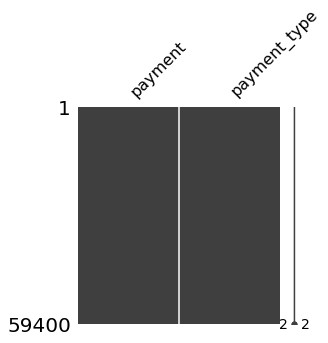

In [573]:
msno.matrix(train[pay], figsize=(4,4), sort='ascending')
plt.show()

In [574]:
cramers = {}
for m in pay:
    cramers[m] = cramers_v(train[m], train['status_group'])

cramers

{'payment': 0.18243010577935334, 'payment_type': 0.18243010577935334}

indifferent to choose one or the other; no missing values and same Cramer's. It looks like the columns are just the same.

### water quality

In [575]:
qual = ['water_quality', 'quality_group']

In [576]:
train[qual].nunique()

water_quality    8
quality_group    6
dtype: int64

In [577]:
msno.matrix(train[qual], figsize=(4,4), sort='ascending')
plt.show()

In [578]:
cramers = {}
for m in qual:
    cramers[m] = cramers_v(train[m], train['status_group'])

cramers

{'water_quality': 0.13803116928255116, 'quality_group': 0.13264363276938332}

`water_quality` is only slightly more correlated to the outcome, and there are 8 categories vs 6 in `quality_group`. So it may not be worth to add two more sparse columns for such a minor increase in correlation; I'll stick with the second.

### water quantity

In [579]:
quan = ['quantity', 'quantity_group']

In [580]:
train[quan].nunique()

quantity          5
quantity_group    5
dtype: int64

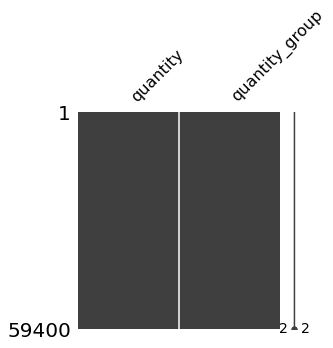

In [581]:
msno.matrix(train[quan], figsize=(4,4), sort='ascending')
plt.show()

In [582]:
cramers = {}
for m in quan:
    cramers[m] = cramers_v(train[m], train['status_group'])

cramers

{'quantity': 0.3091362740452046, 'quantity_group': 0.3091362740452046}

again the same feature twice; stick with `quantity`

### source

In [583]:
source = ['source', 'source_type', 'source_class']

In [584]:
train[source].nunique()

source          10
source_type      7
source_class     3
dtype: int64

In [585]:
msno.matrix(train[source], figsize=(4,4), sort='ascending')
plt.show()

In [586]:
cramers = {}
for m in source:
    cramers[m] = cramers_v(train[m], train['status_group'])

cramers

{'source': 0.14811059560973563,
 'source_type': 0.12629334316907617,
 'source_class': 0.07024985234472723}

`source_class` doesn't correlate particularly well with the outcome variable. The other two do moderately; I'll keep `source` which correlates more despite going to add a few extra sparse columns.

### waterpoint

In [587]:
wpt = ['waterpoint_type', 'waterpoint_type_group']

In [588]:
train[wpt].nunique()

waterpoint_type          7
waterpoint_type_group    6
dtype: int64

In [589]:
msno.matrix(train[wpt], figsize=(4,4), sort='ascending')
plt.show()

In [590]:
cramers = {}
for m in wpt:
    cramers[m] = cramers_v(train[m], train['status_group'])

cramers

{'waterpoint_type': 0.25022829400607893,
 'waterpoint_type_group': 0.22669079655239402}

will keep `waterpoint_type`.

### population

In [591]:
sns.distplot(train['population'], kde=False)
plt.show()

there are no missing values here but there is a very large amount of 0s. Although some of these may refer to uninhabited areas, it's unlikely that _all_ the zeros represent this, and some are probably missing data being imputed at some point. It is not possible to know which 0 is which case; I will instead add a boolean variable that will denote if population is 0 or not and add it to the dataset, and in future steps see if the addition of this variable influences a model's performance.

## construction year

somehow I totally missed this feature the first time around! Should have come up with a better way to do the analysis above.

In [592]:
sns.distplot(train['construction_year'], kde=False)
plt.show()

Like with population, there seem to be some missing values which are coded as 0s.

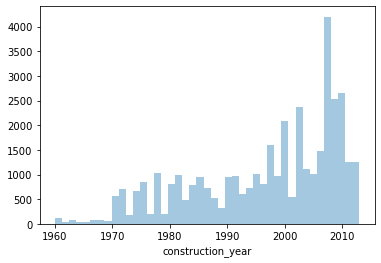

In [593]:
sns.distplot(train.loc[train.construction_year > 1000, 'construction_year'], kde=False)
plt.show()

will fillna with the median, _after_ adding a boolean feature indicating which were initially NAs.

In [594]:
train_x.loc[train_x.construction_year > 1000, 'construction_year'].median()

2000.0

## missing values

- `longitude`, `latitude`:
use `coords_imput.csv` to impute zeros with the median values for the point's `region_group`
- `scheme_management` put NAs into the `Other` category

In [595]:
train_x.scheme_management = train_x.scheme_management.fillna('Other')

- `extraction_type_class`: no NAs in training set
- `management`: regroup some generic categories

In [596]:
train_x['management'] = train_x['management'].replace('unknown', 'other')
train_x['management'] = train_x['management'].replace('other - school', 'school')

- `payment`: no NAs in training
- `quality_group`: no NAs in training
- `quantity`: no NAs in training
- `source`: no NAs in training
- `waterpoint_type`: no NAs in training
- `amount_tsh`: no NAs in training
- `date_recorded`: no NAs in training
- `gps_height`: no NAs in training
- `population`: no NAs in training
- `public_meeting`: more Trues that Falses, so NAs will be filled with True

In [597]:
train_x.public_meeting = train_x.public_meeting.fillna(True)

- `funder`: fill NAs with "unknown"
- `installer`: fill NAs with "unknown"

In [598]:
train_x.funder = train_x.funder.fillna('unknown')
train_x.installer = train_x.installer.fillna('unknown')

- `construction_year`: fill NAs with 2000, add boolean column. FILL AFTER NORMALIZATION to not skew the scaler!

In [599]:
train_x['construction_year_missing'] = train_x['construction_year'] < 1000
train_x.loc[train_x['construction_year'] < 1000, 'construction_year'] = [np.nan] * len(train_x[train_x['construction_year'] < 1000])

### other features

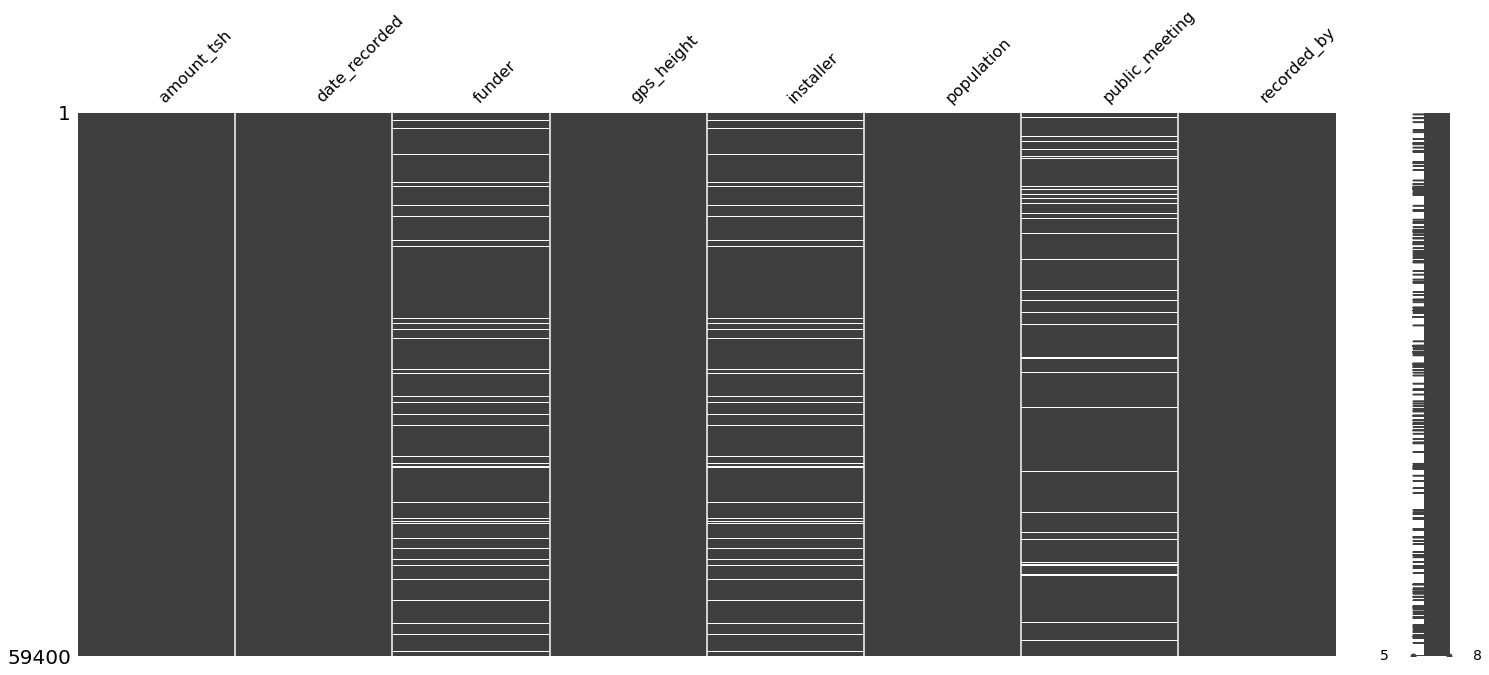

In [600]:
others = ['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'population',
          'public_meeting', 'recorded_by']

msno.matrix(train[others])
plt.show()

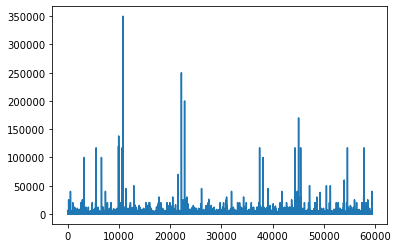

In [601]:
train.amount_tsh.plot()
plt.show()

In [602]:
train.date_recorded.value_counts().plot()
plt.show()

In [603]:
train.gps_height.plot(kind='hist')
plt.show()

In [604]:
train.recorded_by.value_counts()
# useless feature

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [605]:
train.public_meeting.value_counts()
# more Trues than Falses so I'll fillna with True

True     51011
False     5055
Name: public_meeting, dtype: int64

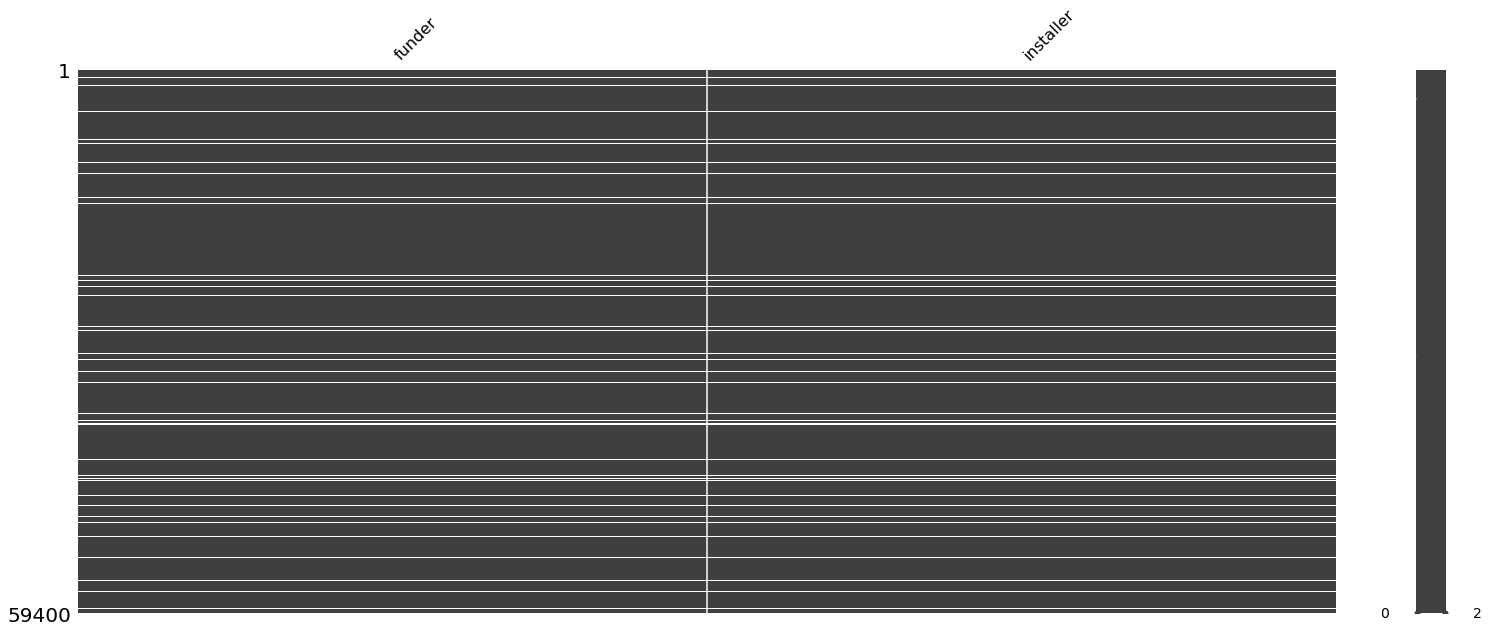

In [606]:
msno.matrix(train[['funder', 'installer']])
plt.show()

values are missing in pairs (funder, installer). They do not always match (more installers than funders). There are many different values for these categories which makes me think if it is a good idea to keep them or not -- we would add a huge amount of boolean columns when one-hot-encoding this.

In [607]:
print(train.installer.nunique(), train.funder.nunique())

2145 1897


In [608]:
cramers = {}
for m in ['installer', 'funder']:
    cramers[m] = cramers_v(train[m], train['status_group'])

cramers

{'installer': 0.3059323504743069, 'funder': 0.3050947684337318}

disappointingly (ha) these correlate somewhat with the outcome. so getting rid of them without further analysis is not a good idea! given their meaning, the missing values can be filled with "unknown" for now. In following steps maybe these features can be summarized.

### adding boolean `population_0`

In [609]:
train_x['population_0'] = train_x.population == 0

## final set of chosen features

In [610]:
features = ['longitude_imp', 'latitude_imp', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'basin', 
            'scheme_management', 'extraction_type_class', 'management', 'population', 'population_0', 
            'public_meeting', 'payment', 'quality_group', 'quantity', 'source', 'waterpoint_type',
            'construction_year_missing', 'construction_year']

In [611]:
train_x = train_x[['id'] + features]

## normalization

the only numeric features are `latitude` and `longitude` so these are the ones that should be normalized. Since most other features are booleans (i.e. either 0 or 1), it seems like a good idea to transform these features into a similar range. However some features are very skewed, so this type of normalization is not ideal.

In [612]:
numeric = ['latitude_imp', 'longitude_imp', 'gps_height', 'amount_tsh', 'population', 'construction_year']
train_x[numeric].dtypes

latitude_imp         float64
longitude_imp        float64
gps_height             int64
amount_tsh           float64
population             int64
construction_year    float64
dtype: object

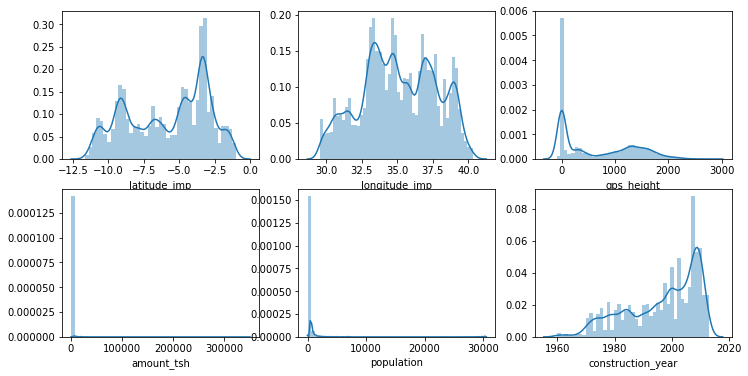

In [613]:
_, ax = plt.subplots(2,3, figsize=(12,6))

for i, c in enumerate(numeric):
    sns.distplot(train_x[c], ax=ax[i//3][i%3])

MinMaxScaler is a good choice for the first three + construction year, which are distributed in a somewhat uniform way across the range of recorded values. amount_tsh and population will require a more robust scaler.

In [614]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [615]:
scaler = MinMaxScaler()
# fit on training data only
scaler.fit(X_train[['latitude_imp', 'longitude_imp', 'gps_height', 'construction_year']])


train_x['construction_year'] = train_x['construction_year'].fillna(2000)
train_x[['latitude_imp', 'longitude_imp', 'gps_height', 'construction_year']] = scaler.transform(train_x[['latitude_imp', 'longitude_imp', 'gps_height', 'construction_year']])

In [616]:
from sklearn.externals import joblib

scaler_filename = "../../data/external/scaler_minmax.save"
joblib.dump(scaler, scaler_filename)

['../../data/external/scaler_minmax.save']

In [617]:
scaler = StandardScaler()
# fit on training data only
scaler.fit(X_train[['population', 'amount_tsh']])

train_x[['population', 'amount_tsh']] = scaler.transform(train_x[['population', 'amount_tsh']])

In [618]:
from sklearn.externals import joblib

scaler_filename = "../../data/external/scaler_standard.save"
joblib.dump(scaler, scaler_filename)

['../../data/external/scaler_standard.save']

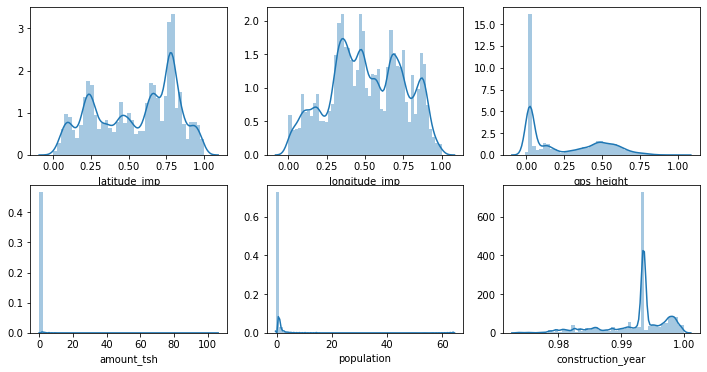

In [619]:
_, ax = plt.subplots(2,3, figsize=(12,6))

for i, c in enumerate(numeric):
    sns.distplot(train_x[c], ax=ax[i//3][i%3])

# write function

In [622]:
def base_transformations(df, path_to_repo_root='/home/ana/Documents/DDT/pumpitup'):
    
    # replacing 0s in coordinates
    coord_imput = pd.read_csv(f"{path_to_repo_root}/data/external/imput_coords.csv")
    df.loc[:, 'longitude_imp'] = df['longitude']
    df.loc[:, 'latitude_imp'] = df['latitude']
    
    for r in df.loc[np.isclose(df.longitude, 0), 'region_code'].unique():

        n = 0
        lat = 0
        lon = 0

        try:
            lat = coord_imput.loc[r, 'latitude']
            lon = coord_imput.loc[r, 'longitude']
            n = len(df.loc[(np.isclose(df.longitude, 0)) & (df.region_code == r), :])

            df.loc[(np.isclose(df.longitude, 0)) & (df.region_code == r), 'longitude_imp'] = [lon] * n
            df.loc[(np.isclose(df.longitude, 0)) & (df.region_code == r), 'latitude_imp'] = [lat] * n

        except KeyError:
            print(f'no imput value for {r}')
            continue
    
    df['population_0'] = df.population == 0
    df['construction_year_missing'] = df['construction_year'] < 1000
    
    # selected features (removed redundancy)
    features = ['id', 'longitude_imp', 'latitude_imp', 'amount_tsh', 'date_recorded', 'funder', 
                'gps_height', 'basin', 'scheme_management', 'extraction_type_class', 'management', 
                'population', 'population_0', 'public_meeting', 'payment', 'quality_group', 
                'quantity', 'source', 'waterpoint_type', 'construction_year', 'construction_year_missing']
    df = df.loc[:, features]
    
    # changing repeated categories
    df.loc[:, 'management'] = df['management'].replace('unknown', 'other')
    df.loc[:, 'management'] = df['management'].replace('other - school', 'school')
    
    # fill missing values
    df.loc[:, 'scheme_management'] = df.scheme_management.fillna('Other')
    df.loc[:, 'public_meeting'] = df.public_meeting.fillna(True)
    df.loc[:, 'funder'] = df.funder.fillna('unknown')
    df.loc[df['construction_year'] < 1000, 'construction_year'] = [2000] * len(df[df['construction_year'] < 1000])
    
    # loading trained scalers & scaling data
    scaler = joblib.load(f"{path_to_repo_root}/data/external/scaler_minmax.save") 
    to_scale = ['latitude_imp', 'longitude_imp', 'gps_height', 'construction_year']
    df.loc[:, to_scale] = scaler.transform(df[to_scale])
    
    scaler = joblib.load(f"{path_to_repo_root}/data/external/scaler_standard.save") 
    to_scale = ['population', 'amount_tsh']
    df.loc[:, to_scale] = scaler.transform(df[to_scale])
    
    # expected resulting columns
    expected = ['id', 'longitude_imp', 'latitude_imp', 'amount_tsh', 'date_recorded',
                'funder', 'gps_height', 'basin', 'scheme_management', 'extraction_type_class', 
                'management', 'population', 'population_0', 'public_meeting', 'payment', 
                'quality_group', 'quantity', 'source', 'waterpoint_type', 'construction_year', 
                'construction_year_missing']
    
    for col in set(expected).difference(set(df.columns)):
        print(f"{col} was missing in the original data, filling with 0s")
        df.loc[:, col] = [0] * len(df)
        
    for col in set(df.columns).difference(set(expected)):
        print(f"popping {col} from final dataset")
        df.pop(col)
    
    return df
    

# transform & save

In [623]:
test = pd.read_csv('../../data/raw/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')
test_proc = base_transformations(test, path_to_repo_root='C:/Users/silvia/Documents/D_Documents/pumpitup')

test_proc.to_csv('../../data/interim/test.csv', index=False)

In [624]:
train_x = pd.read_csv('../../data/raw/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
train_proc = base_transformations(train_x, path_to_repo_root='C:/Users/silvia/Documents/D_Documents/pumpitup')
train_proc.to_csv('../../data/interim/train.csv', index=False)

In [625]:
train_y = pd.read_csv('../../data/raw/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
train_y.to_csv('../../data/interim/train_labels.csv', index=False)

In [626]:
train_proc.columns

Index(['id', 'longitude_imp', 'latitude_imp', 'amount_tsh', 'date_recorded',
       'funder', 'gps_height', 'basin', 'scheme_management',
       'extraction_type_class', 'management', 'population', 'population_0',
       'public_meeting', 'payment', 'quality_group', 'quantity', 'source',
       'waterpoint_type', 'construction_year', 'construction_year_missing'],
      dtype='object')